In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import imageio
from glob import glob 

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.map_coordinates.html

import scipy 
from scipy import ndimage


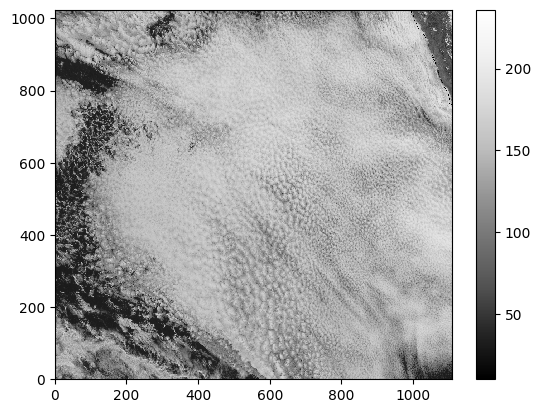

In [2]:


# Define the path to the directory containing the images
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
# Use glob to find the images in the specified path
fnames = np.sort(glob(path + '*9_06*png'))
images = []

# Read the images and process them
for i, fname in enumerate(fnames):
    img = imageio.v2.imread(fname)
    red = np.flipud(img[:, 400:, 0])
    images.append(red)  # Just red channel, just 400:end in the x dir, flip y

# Plot the first processed image
plt.pcolormesh(images[0], cmap='Greys_r')
plt.colorbar()
plt.show()


In [4]:
# Get the dimensions of the image
height, width = red.shape[:2]

# Create 2D arrays of x and y
x = np.arange(width)
y = np.arange(height)

# Create a meshgrid of x and y
X, Y = np.meshgrid(x, y)


# Pixel size: nominal for MKS units to pixel units 
DX = 2000             # m, pixel size (nominal)

# Xm and Ym are Coordinates in meters, distances measured from central point of image
Xm = (X-X.mean())*DX
Ym = (Y-Y.mean())*DX 

## Wave parameters for warping and modulating an image
"In one period, 7–9 October 2008, the waves modulated cloud-top-height by up to 400 m peak-to-trough, propagating perpendicular to the synoptic boundary layer flow with phase speed 15.3 m s−1, period ∼1 h and horizontal wavelength 55 km. The gravity waves were observed to be non-dispersive. “ from https://doi.org/10.1002/qj.1952

For a wave moving toward 45 degrees (northeast), define k and l as positive (sin and cos of nav angle). Let's take z = sin( k(x-ct) + l(y-ct) ) which is indeed moving NEward with time. Then u and v are both positive at z crests (sketch it). That means dx and dy are positve when time is 1/4 period later, or when 90deg of phase have been subtracted since t appears with a negative sign in the formula for phase (x-ct).

In [5]:
# One wave packet 
cphase = 14            # m/s
wavelength = 150*1000. # meters
period = wavelength/cphase 
direction = 225       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude = 100      # meters, vertical displacement
PBLdepth = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k = 2*np.pi/wavelength * np.sin( (direction) *np.pi/180 )   
l = 2*np.pi/wavelength * np.cos( (direction) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x = -400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y = 400*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x  = 400*1000.  # meters
packet_width_y  = 300*1000.  # meters
Ampwindow = np.exp(-( ((Xm-packet_center_x)/packet_width_x)**2 + \
                      ((Ym-packet_center_y)/packet_width_y)**2 )) 
     
#plt.pcolormesh(Ampwindow); plt.colorbar()

In [6]:
# A second wave packet 
cphase2 = 20            # m/s
wavelength2 = 100*1000. # meters
period2 = wavelength2/cphase2 
direction2 = 140       # navigation angle of FROM direction in degrees (225 = FROM SW, toward NE) 
zamplitude2 = 50      # meters, vertical displacement
PBLdepth2 = 1000       # m, divergent winds assumed to be constant through this layer  

# Wavenumbers computed from wavelengths and direction, units radians per meter
k2 = 2*np.pi/wavelength2 * np.sin( (direction2) *np.pi/180 )   
l2 = 2*np.pi/wavelength2 * np.cos( (direction2) *np.pi/180 )   

# Amplitude modulation by a big smooth Gaussian 
packet_center_x2 = 400*1000  # meters, from middle of Xm, Ym coordinates  
packet_center_y2 = 100*1000   # meters, from middle of Xm, Ym coordinates  
packet_width_x2  = 200*1000.  # meters
packet_width_y2  = 600*1000.  # meters
Ampwindow2 = np.exp(-( ((Xm-packet_center_x2)/packet_width_x2)**2 + \
                      ( (Ym-packet_center_y2)/packet_width_y2)**2 )) 

### Animation displays for time-dependent warped imagery texture

In [7]:
# Constants for this animation 
time_steps = 10            # Number of time steps 
time_resolution = 1800     # seconds, images are half an hour apart

# The resulting image arrays, for animation 
grid = np.zeros((height, width, time_steps))


# BUILD THE WARPED MODULATED IMAGES AT EACH TIME

for it in range(time_steps):
    t = it*time_resolution     # t is in seconds 

# dz measures vertical displacements: let's choose the sine function. Two packets 
    dz = zamplitude \
         * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) ) *Ampwindow 
    dz2 = zamplitude2 \
         * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) ) *Ampwindow2

# wave dx and dy are 90deg behind phase with dz, prop. to wavelength. 
# DIRECTION: For 45deg (wave going NE), k>0,l>0, dx>0,dy>0 (sketch it). 

    dxy = (zamplitude/PBLdepth)*wavelength \
          * np.sin( k*(Xm - cphase*t)+l*(Ym - cphase*t) -np.pi/2.) /DX
    dx = dxy * np.sin(direction *np.pi/180.) *Ampwindow # why /2? because it is too strong. Pixel units?? 
    dy = dxy * np.cos(direction *np.pi/180.) *Ampwindow

    dxy2= (zamplitude2/PBLdepth2)*wavelength2 \
          * np.sin( k2*(Xm - cphase2*t)+l2*(Ym - cphase2*t) -np.pi/2.) /DX
    dx2= dxy2* np.sin(direction2 *np.pi/180.) *Ampwindow2 
    dy2= dxy2* np.cos(direction2 *np.pi/180.) *Ampwindow2

# Warping by transporting pixels in original red image, wrapping (periodic) for now. SUBTRACT dy and dx in argument. 
    grid[:,:,it] = ndimage.map_coordinates(images[it],[Y-dy-dy2, X-dx-dx2])  

# Modulate (multiply) albedo by a wavy pattern (vertical displacements, 
#           make consistent with xmotion and ymotion arrays above) 
    grid[:,:,it] *= (1 + dz /PBLdepth  *5) 
    grid[:,:,it] *= (1 + dz2/PBLdepth2 *5) 

maxvalue = grid.max()
maxvalue

309.58694301653907

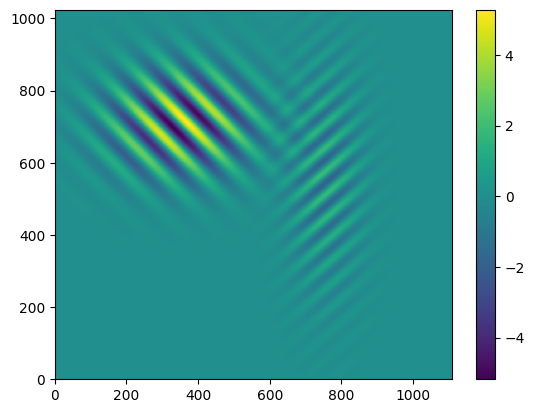

In [8]:
plt.pcolormesh(dy+dy2); plt.colorbar(); # pixels units -- surprising that 7 pixels make such a huge warp?

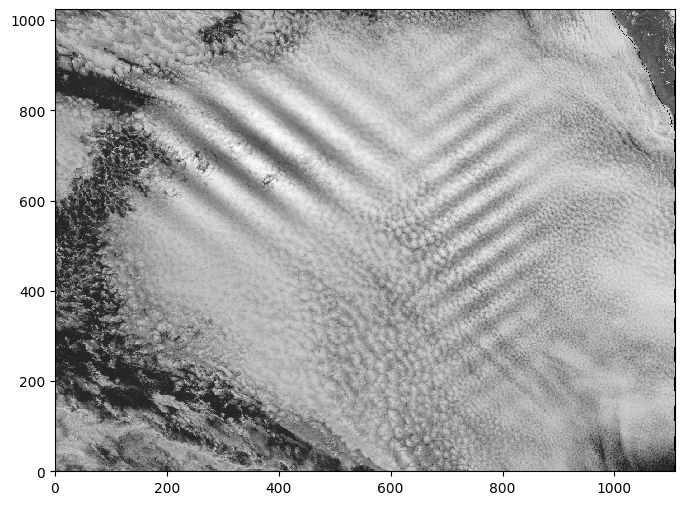

In [9]:
plt.figure(figsize=(8,6))
plt.pcolormesh(grid[:,:,0], cmap='Greys_r')

# Wavelet Image Decomposition

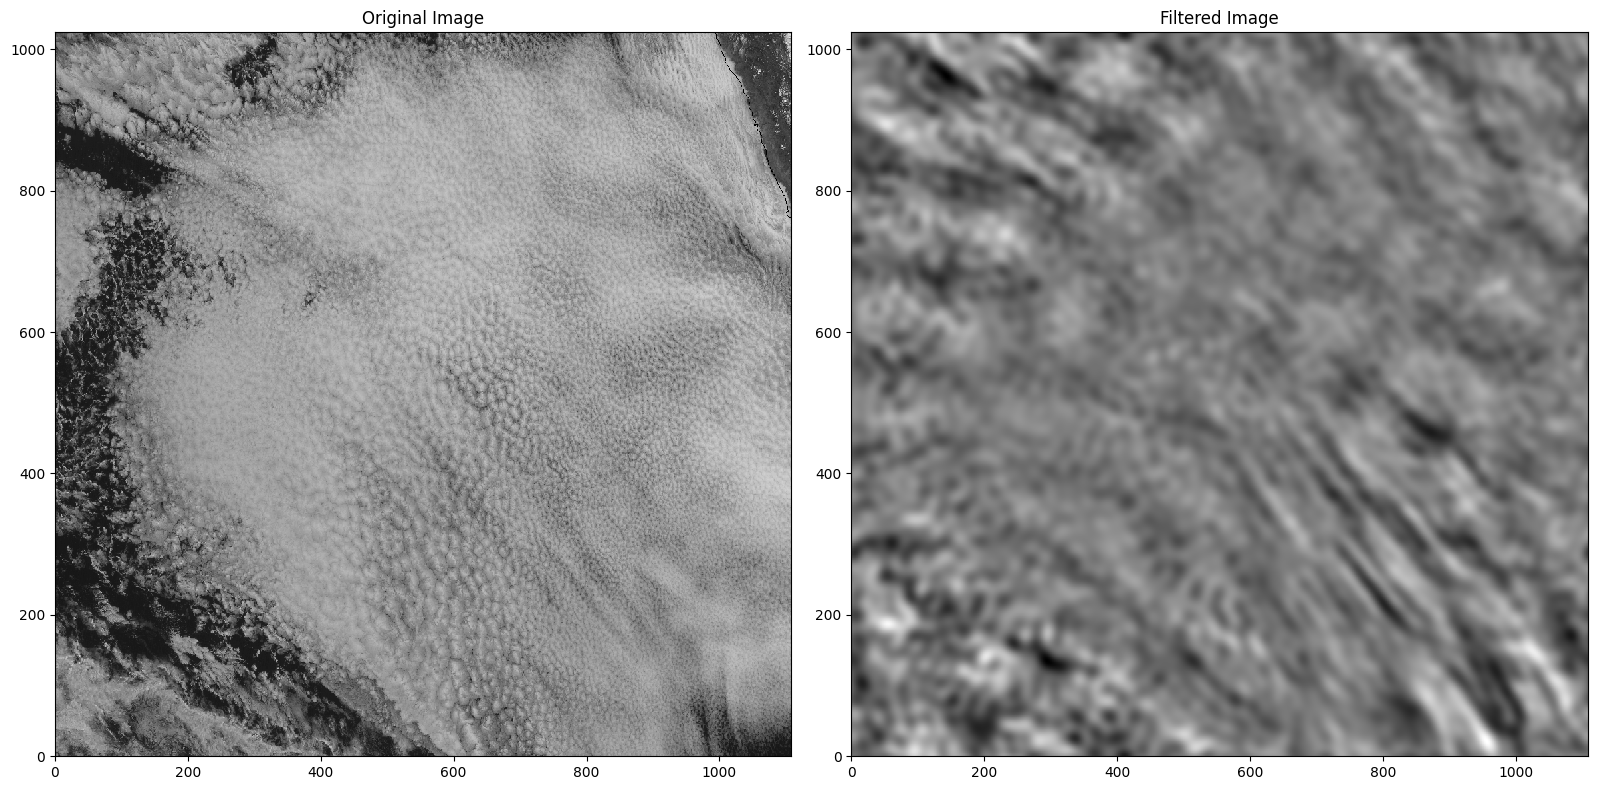

In [10]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

# circular permutation of the dimensions until the third one is the time dimension
images = np.moveaxis(images, 2, 0)
images = np.moveaxis(images, 2, 0)

images_filtered = filter_frames(images, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(images,images[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

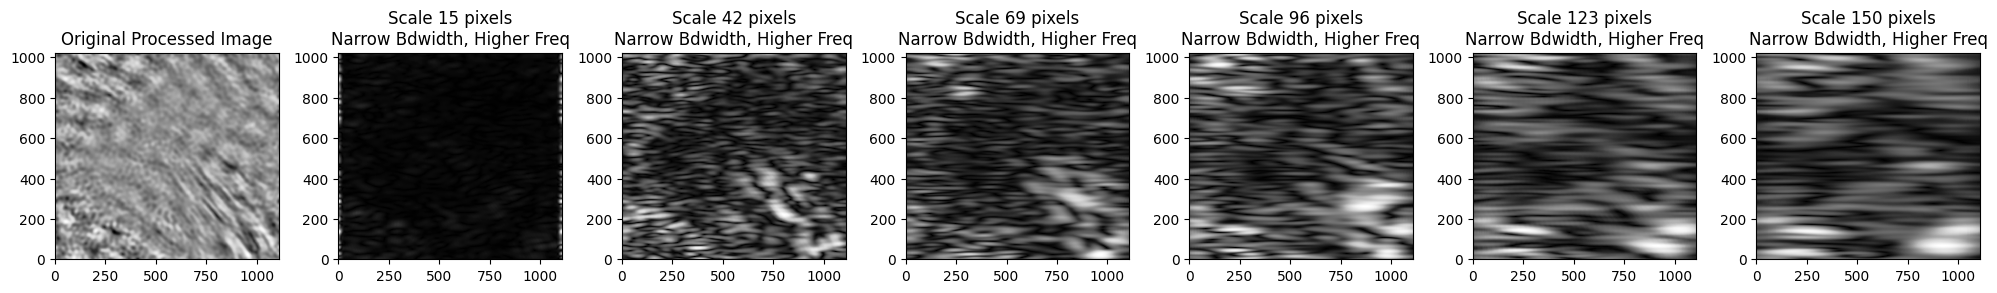

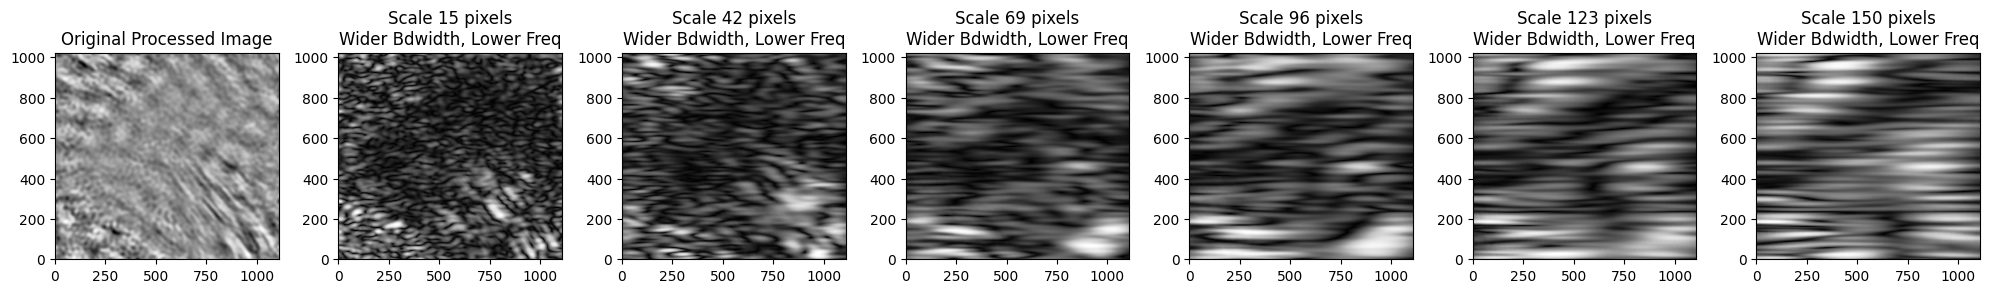

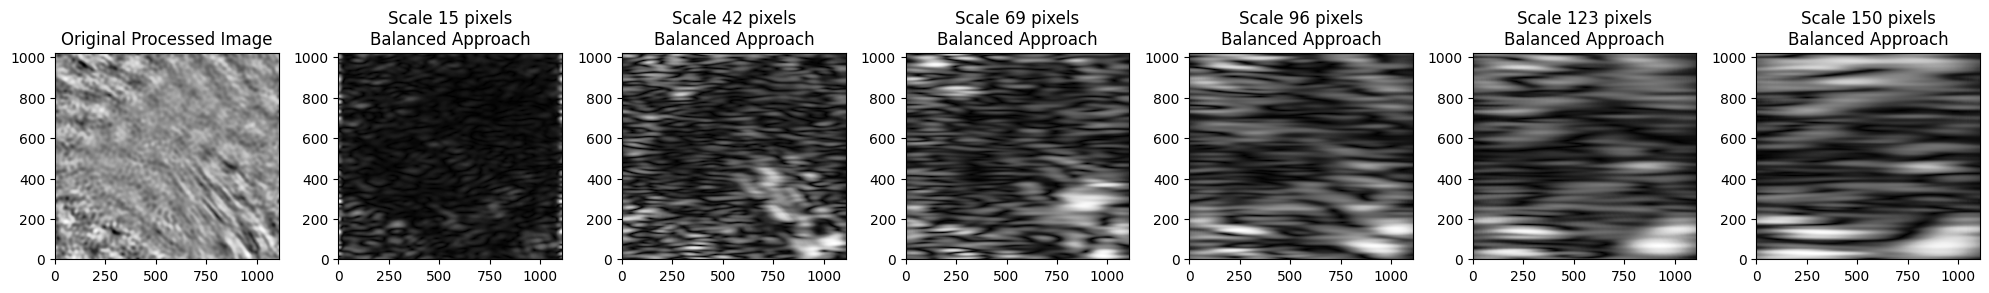

In [10]:
import pywt

# Select the first processed image
image = images_filtered[:,:,0]

# Define the scales for the continuous wavelet transform
# The desired feature sizes are 30 km and 300 km.
# Convert these to pixel scales: 30 km / 2 km/pixel = 15 pixels and 300 km / 2 km/pixel = 150 pixels

# scales = np.arange(15, 151, 15)  # Trying scales from 15 to 150 pixels in steps of 15 pixels
scales = np.arange(15, 151, 27) # Selecting a few representative scales

# Different settings for B and C parameters of the complex Morlet wavelet
wavelet_settings = [
    ('cmor1.0-1.0', 'Narrow Bdwidth, Higher Freq'),
    ('cmor2.0-0.5', 'Wider Bdwidth, Lower Freq'),
    ('cmor1.5-0.8', 'Balanced Approach')
]

for wavelet_name, description in wavelet_settings:
    wavelet = pywt.ContinuousWavelet(wavelet_name)

    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(20, 5))

    # Plot the original processed image
    axes[0].pcolormesh(image, cmap='Greys_r')
    axes[0].set_title('Original Processed Image')
    axes[0].set_aspect('equal')

    # Apply the continuous wavelet transform (CWT) with the complex Morlet wavelet for different scales
    for i, scale in enumerate(scales):
        coefficients, frequencies = pywt.cwt(image, [scale], wavelet)
        magnitude = np.abs(coefficients[0])  # Take the magnitude of the complex coefficients
        axes[i + 1].pcolormesh(magnitude, cmap='Greys_r')
        axes[i + 1].set_title(f'Scale {scale} pixels\n{description}')
        axes[i + 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

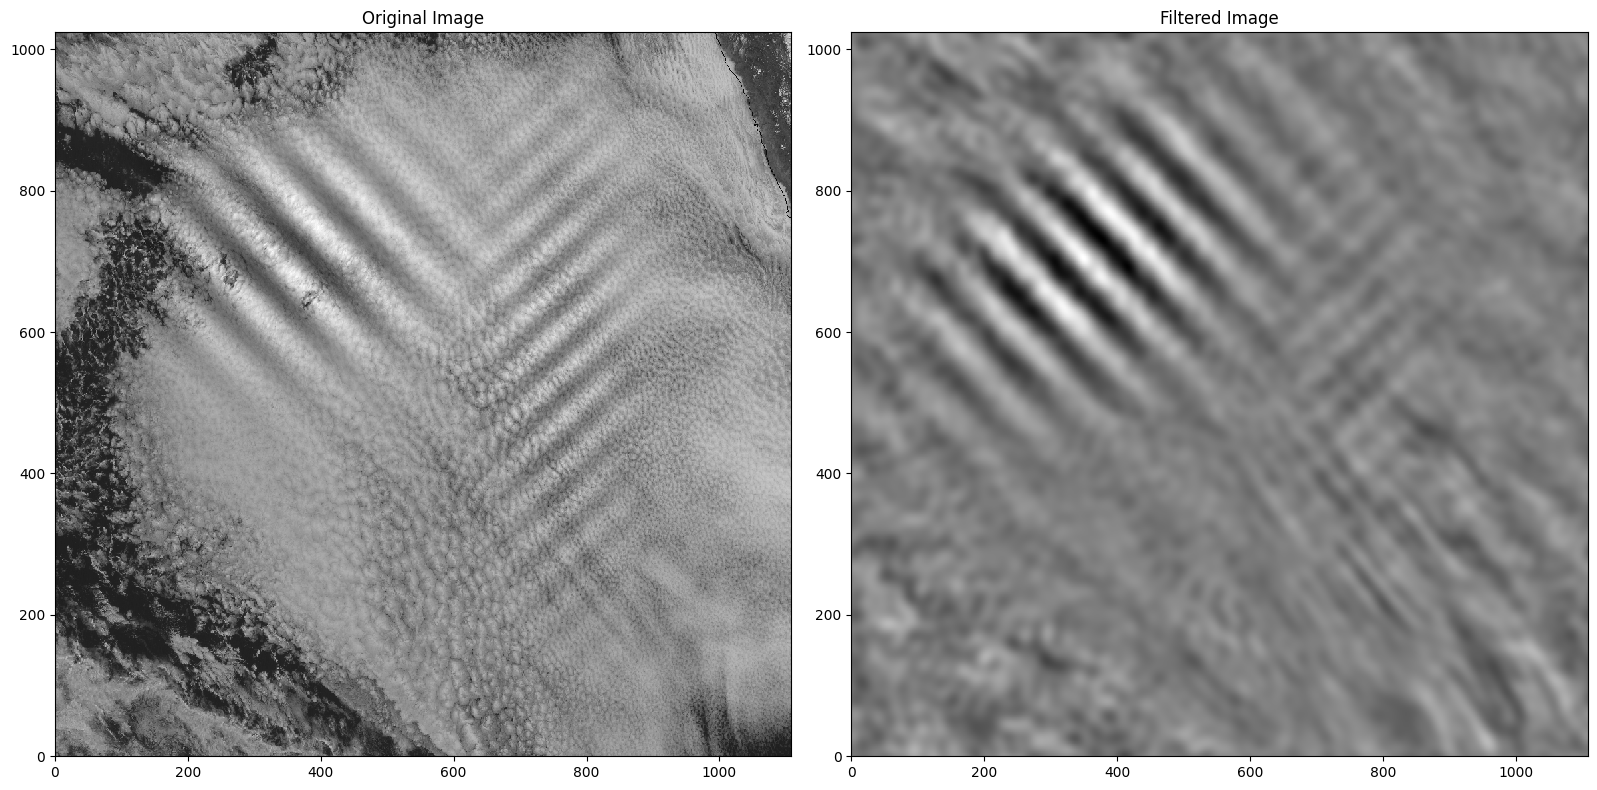

In [11]:
from Eof_functions import filter_frames
from Eof_functions import Visualize_Filter
kl_inf = 0
kl_sup = 1
c_inf = 12
c_sup = 16

images_filtered = filter_frames(grid, kl_inf, kl_sup, c_inf, c_sup)

Visualize_Filter(grid,grid[0],kl_cutoff_inf=kl_inf,kl_cutoff_sup=kl_sup, c_cutoff_inf=c_inf, c_cutoff_sup=c_sup, Amp=False)

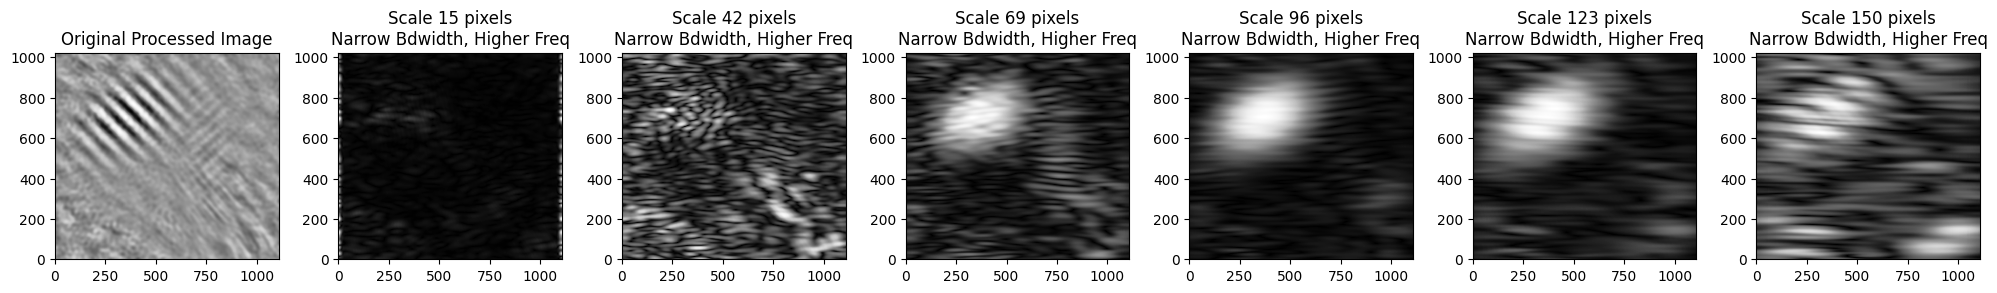

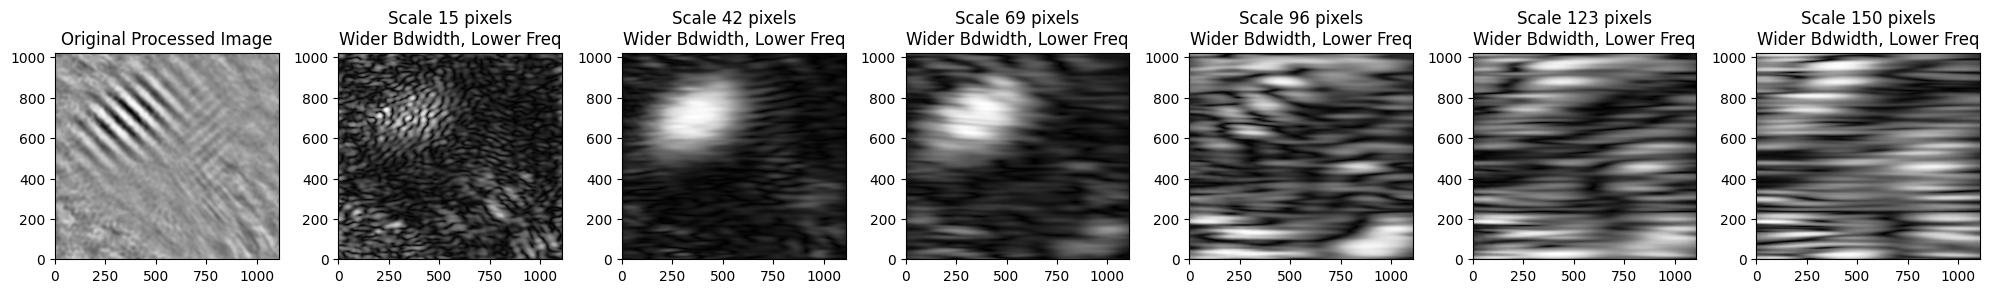

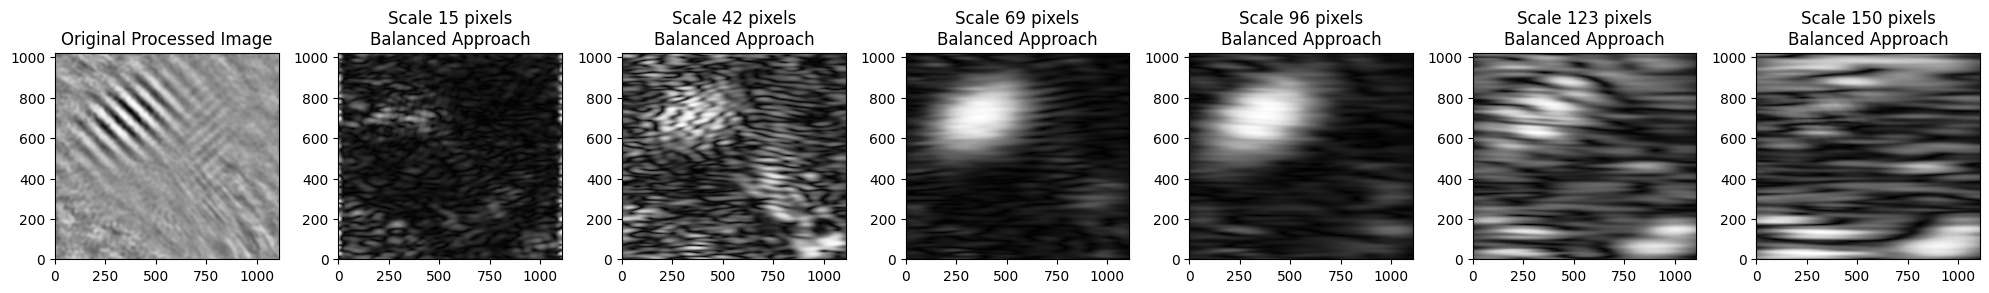

In [12]:
import pywt

# Select the first processed image
image = images_filtered[:,:,0]

# Define the scales for the continuous wavelet transform
# The desired feature sizes are 30 km and 300 km.
# Convert these to pixel scales: 30 km / 2 km/pixel = 15 pixels and 300 km / 2 km/pixel = 150 pixels

# scales = np.arange(15, 151, 15)  # Trying scales from 15 to 150 pixels in steps of 15 pixels
scales = np.arange(15, 151, 27) # Selecting a few representative scales

# Different settings for B and C parameters of the complex Morlet wavelet
wavelet_settings = [
    ('cmor1.0-1.0', 'Narrow Bdwidth, Higher Freq'),
    ('cmor2.0-0.5', 'Wider Bdwidth, Lower Freq'),
    ('cmor1.5-0.8', 'Balanced Approach')
]

for wavelet_name, description in wavelet_settings:
    wavelet = pywt.ContinuousWavelet(wavelet_name)

    fig, axes = plt.subplots(1, len(scales) + 1, figsize=(20, 5))

    # Plot the original processed image
    axes[0].pcolormesh(image, cmap='Greys_r')
    axes[0].set_title('Original Processed Image')
    axes[0].set_aspect('equal')

    # Apply the continuous wavelet transform (CWT) with the complex Morlet wavelet for different scales
    for i, scale in enumerate(scales):
        coefficients, frequencies = pywt.cwt(image, [scale], wavelet)
        magnitude = np.abs(coefficients[0])  # Take the magnitude of the complex coefficients
        axes[i + 1].pcolormesh(magnitude, cmap='Greys_r')
        axes[i + 1].set_title(f'Scale {scale} pixels\n{description}')
        axes[i + 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

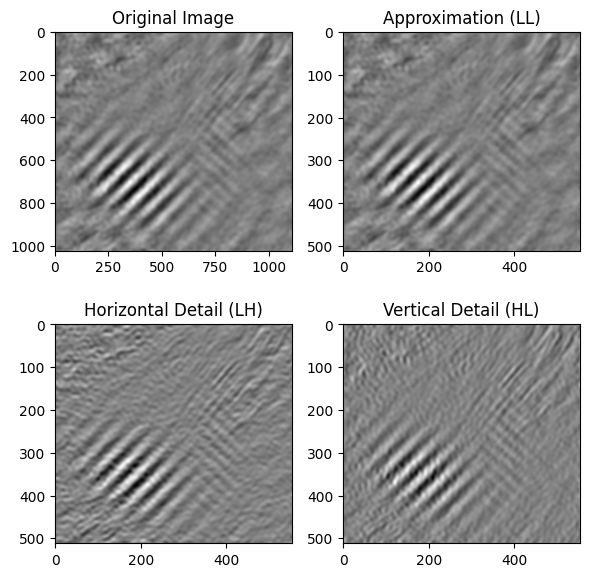

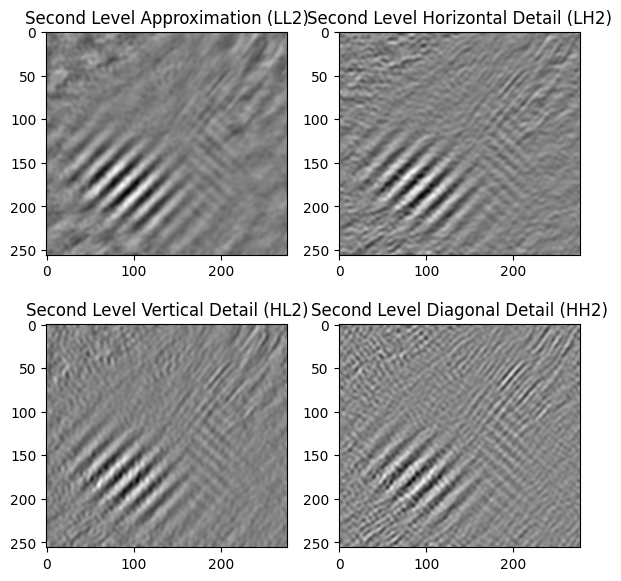

In [13]:
# Select the first processed image
image = images_filtered[:,:,0]

# Perform a single level 2D wavelet decomposition
coeffs2 = pywt.dwt2(image, 'haar')
LL, (LH, HL, HH) = coeffs2

# Plot the original image and the wavelet coefficients
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')

axes[0, 1].imshow(LL, cmap='gray')
axes[0, 1].set_title('Approximation (LL)')

axes[1, 0].imshow(LH, cmap='gray')
axes[1, 0].set_title('Horizontal Detail (LH)')

axes[1, 1].imshow(HL, cmap='gray')
axes[1, 1].set_title('Vertical Detail (HL)')

plt.tight_layout()
plt.show()

# Second level decomposition
coeffs2_level2 = pywt.dwt2(LL, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2_level2

# Plot the second level decomposition
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(LL2, cmap='gray')
axes[0, 0].set_title('Second Level Approximation (LL2)')

axes[0, 1].imshow(LH2, cmap='gray')
axes[0, 1].set_title('Second Level Horizontal Detail (LH2)')

axes[1, 0].imshow(HL2, cmap='gray')
axes[1, 0].set_title('Second Level Vertical Detail (HL2)')

axes[1, 1].imshow(HH2, cmap='gray')
axes[1, 1].set_title('Second Level Diagonal Detail (HH2)')

plt.tight_layout()
plt.show()

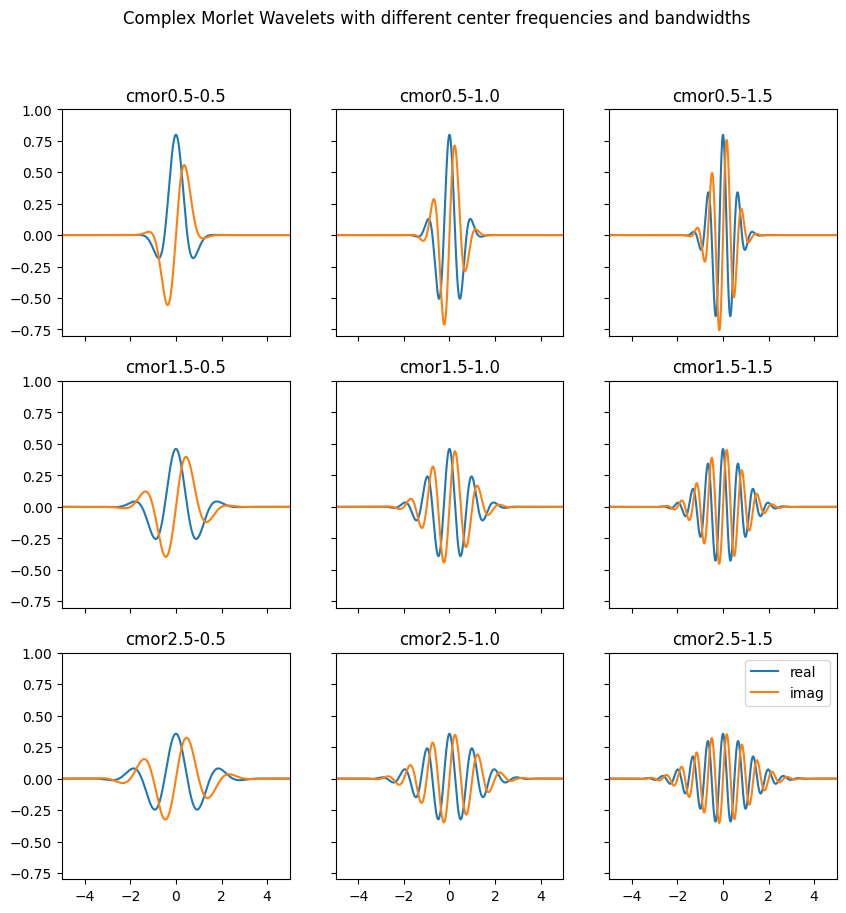

In [14]:
# plot complex morlet wavelets with different center frequencies and bandwidths
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

# cmor0.5-1.0


C:\Users\ratynski\AppData\Local\Temp\ipykernel_10632\2503430634.py:31: RuntimeWarning: invalid value encountered in divide
  reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())


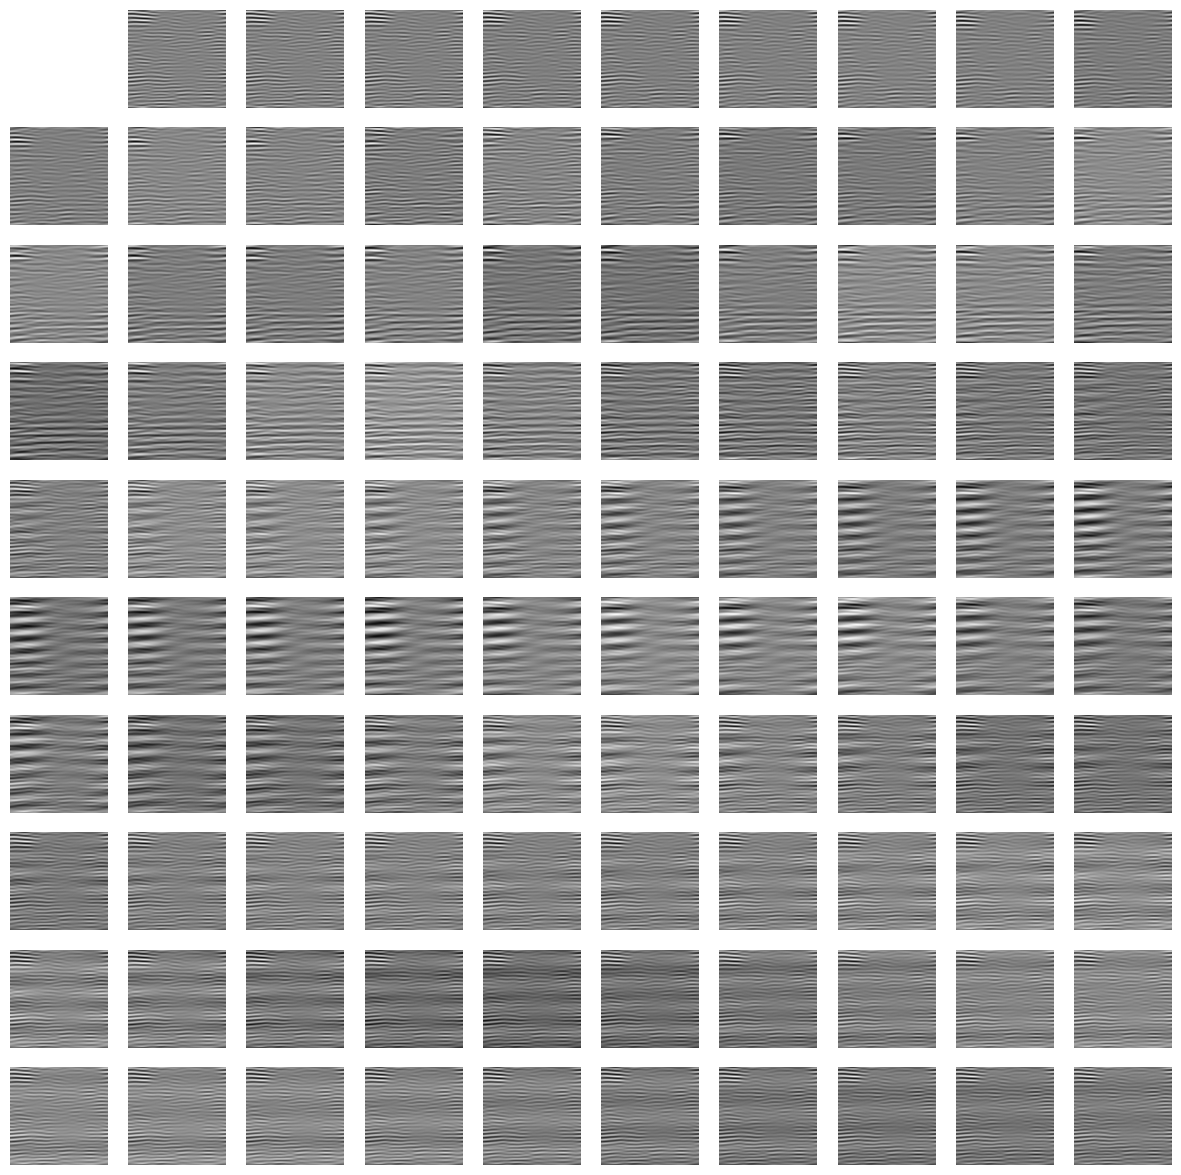

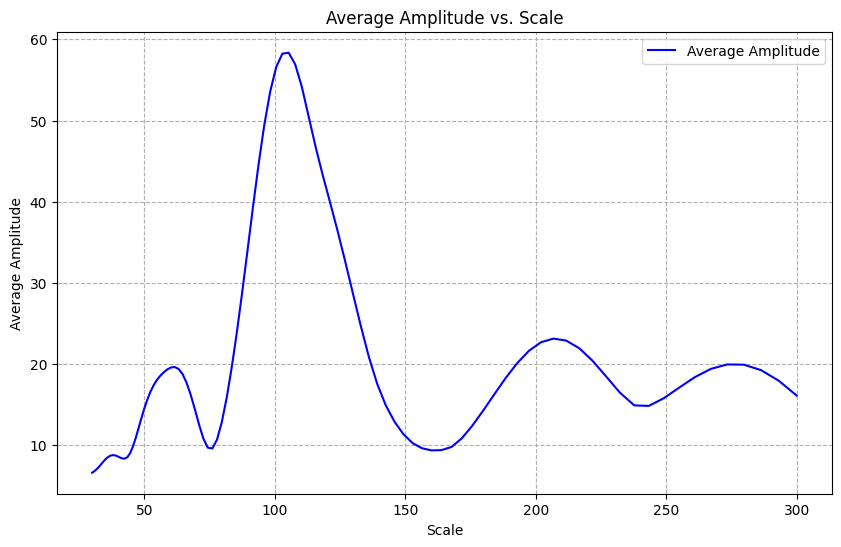

In [221]:
import numpy as np
import pywt
from matplotlib import pylab as plt
import py_cwt2d

# Get the image
image = images_filtered[:,:,0]
# ensure the image is square
image = image[:image.shape[0], :image.shape[0]]
# image = pywt.data.camera()
# image = (image - image.min()) / (image.max() - image.min())

# Set up a range of scales 
ss = np.geomspace(30, 300, 100)
#ss = np.geomspace(1.0, 256.0, 100)

# Calculate the complex pycwt and the wavelet normalizations
coeffs, wav_norm = py_cwt2d.cwt_2d(image, ss, 'cmor')  # Ensure 'cmor' from the updated wavelets dictionary is added manually

# Plot an image showing the combinations of all the scales
errors = []
N = 10
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
for level in range(len(ss)):
    i = level // N
    j = level % N
    plt.sca(axes[i, j])
    plt.axis('off')
    C = 1.0 / (ss[:level] * wav_norm[:level])
    reconstruction = (C * np.real(coeffs[..., :level])).sum(axis=-1)
    reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    errors.append(np.sqrt(np.sum(np.power(reconstruction - image, 2.0))))
    plt.imshow(reconstruction, cmap='gray')
plt.show()

# fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6 / 1.618))
# plt.plot(errors, label='norm')
# plt.xlabel('Number of Reconstruction Scales')
# plt.ylabel('Reconstruction Error')
# plt.show()

# Compute the average amplitude for each scale
average_amplitudes = np.zeros(len(ss))

for i, scale in enumerate(ss):
    avg_amplitude = np.mean(np.abs(coeffs[..., i]))
    average_amplitudes[i] = avg_amplitude

# Plot the average amplitude for each scale
plt.figure(figsize=(10, 6))
plt.plot(ss, average_amplitudes, label='Average Amplitude', color='b')
# plt.xscale('log')  # Log scale for x-axis to match the scale range
# plt.yscale('log')  # Log scale for y-axis to emphasize variations
plt.xlabel('Scale')
plt.ylabel('Average Amplitude')
plt.title('Average Amplitude vs. Scale')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


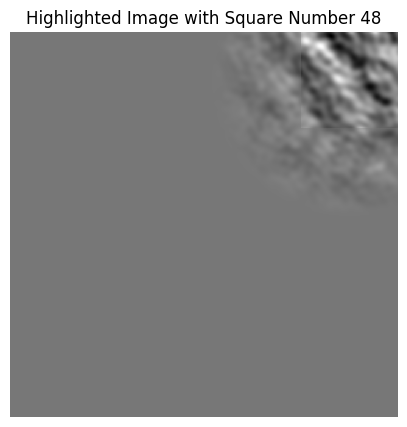

In [165]:
data_shape = image.shape

square_number = 48
# square_size = 409
square_size = 256
overlap = 0.5
strength = 0.5


mask = None
if square_number is not None:
    step_size = int(square_size * (1 - overlap))
    num_squares_per_row = (data_shape[1] - square_size) // step_size + 1
    
    i = (square_number // num_squares_per_row) * step_size
    j = (square_number % num_squares_per_row) * step_size

    # Create a mask for the entire frame
    mask = np.zeros((data_shape[0], data_shape[1]))

    # Create a 2D radial gradient mask for the area outside the square
    y, x = np.ogrid[:data_shape[0], :data_shape[1]]
    center_y, center_x = i + square_size // 2, j + square_size // 2
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
    gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

    # Apply the gradient mask to the area outside the central square
    mask[i:i+square_size, j:j+square_size] = 1
    mask = np.maximum(mask, gradient_mask)

    # Apply the mask to all frames
    image_highlighted = image * mask

    # Plot the highlighted image
    plt.figure(figsize=(5, 5))
    plt.pcolormesh(image_highlighted, cmap='gray')
    plt.title(f"Highlighted Image with Square Number {square_number}")
    plt.axis('off')
    plt.show()


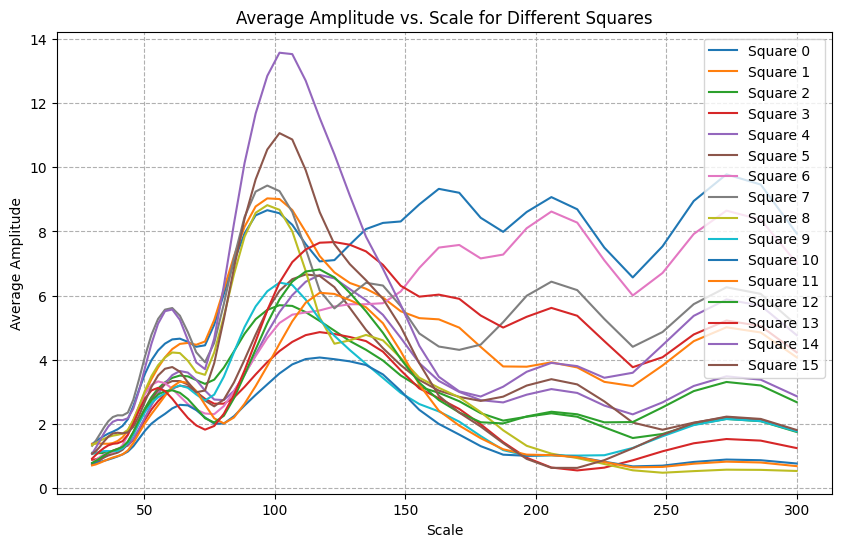

In [143]:
import numpy as np
import pywt
from matplotlib import pylab as plt
import py_cwt2d

# Get the image
image = images_filtered[:,:,0]
# Ensure the image is square
image = image[:image.shape[0], :image.shape[0]]

# Set up a range of scales
ss = np.geomspace(30, 300, 50)

data_shape = image.shape
square_size = 256 # Only the first 16 squares are plotted
overlap = 0.5
strength = 0.5

# Prepare the plot for average amplitude vs. scale
plt.figure(figsize=(10, 6))

# Loop through each square number
for square_number in range(16): #Plotted the first 16 squares
    mask = None
    if square_number is not None:
        step_size = int(square_size * (1 - overlap))
        num_squares_per_row = (data_shape[1] - square_size) // step_size + 1

        i = (square_number // num_squares_per_row) * step_size
        j = (square_number % num_squares_per_row) * step_size

        # Create a mask for the entire frame
        mask = np.zeros((data_shape[0], data_shape[1]))

        # Create a 2D radial gradient mask for the area outside the square
        y, x = np.ogrid[:data_shape[0], :data_shape[1]]
        center_y, center_x = i + square_size // 2, j + square_size // 2
        distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
        gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

        # Apply the gradient mask to the area outside the central square
        mask[i:i+square_size, j:j+square_size] = 1
        mask = np.maximum(mask, gradient_mask)

        # Apply the mask to the image
        image_highlighted = image * mask

        # Perform the 2D continuous wavelet transform using the complex Morlet wavelet
        coeffs, wav_norm = py_cwt2d.cwt_2d(image_highlighted, ss, 'cmor')

        # Compute the average amplitude for each scale
        average_amplitudes = np.zeros(len(ss))
        for idx, scale in enumerate(ss):
            avg_amplitude = np.mean(np.abs(coeffs[..., idx]))
            average_amplitudes[idx] = avg_amplitude

        # Plot the average amplitude for each scale
        plt.plot(ss, average_amplitudes, label=f'Square {square_number}')

# Finalize the plot
plt.xlabel('Scale')
plt.ylabel('Average Amplitude')
plt.title('Average Amplitude vs. Scale for Different Squares')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


In [222]:
# Load the image
image = images_filtered[:,:,0]

# Ensure the image is square
image = image[:image.shape[0], :image.shape[0]]

# Set up a range of scales
scales = np.geomspace(15, 150, 10)

# Define parameters
square_size = 256
overlap = 0.5
strength = 0.5

data_shape = image.shape
step_size = int(square_size * (1 - overlap))
num_squares_per_row = (data_shape[1]) // step_size 
num_squares_per_col = (data_shape[0]) // step_size 

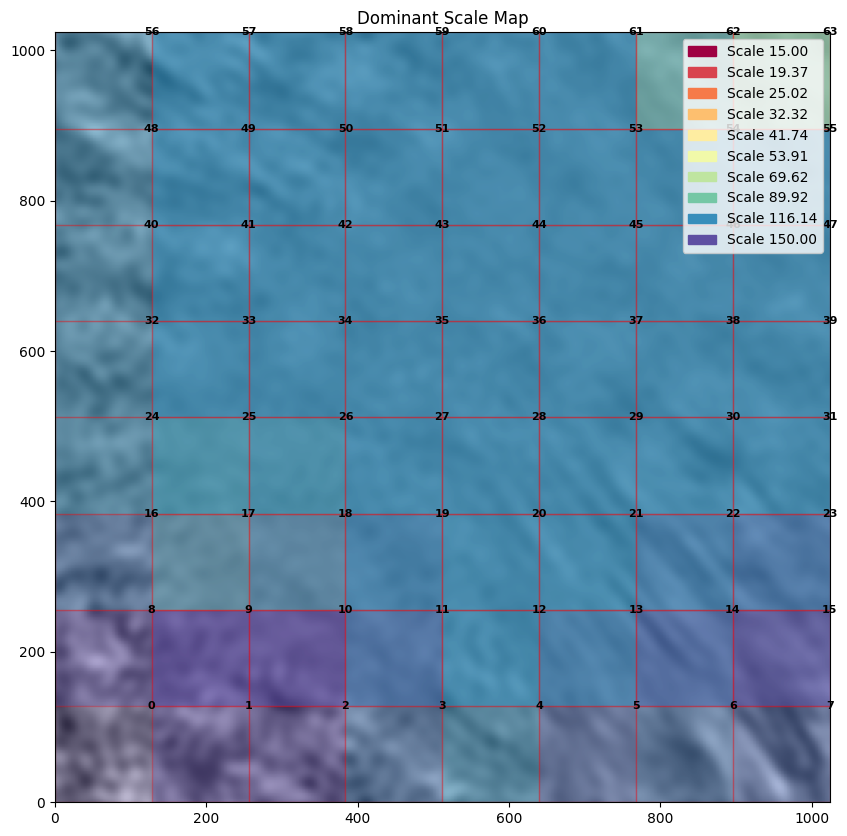

In [206]:
# Loop through each square number
average_amplitudes_all_squares = []
dominant_scales = {}
for square_number in range(num_squares_per_row * num_squares_per_col):
    mask = None
    if square_number is not None:
        i = (square_number // num_squares_per_row) * step_size
        j = (square_number % num_squares_per_row) * step_size

        # Create a mask for the entire frame
        mask = np.zeros((data_shape[0], data_shape[1]))

        # Create a 2D radial gradient mask for the area outside the square
        y, x = np.ogrid[:data_shape[0], :data_shape[1]]
        center_y, center_x = i + square_size // 2, j + square_size // 2
        distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        max_distance = strength * np.sqrt((data_shape[0] / 2)**2 + (data_shape[1] / 2)**2)
        gradient_mask = 1 - np.clip(distance_from_center / max_distance, 0, 1)

        # Apply the gradient mask to the area outside the central square
        mask[i:i+square_size, j:j+square_size] = 1
        mask = np.maximum(mask, gradient_mask)

        # Apply the mask to the image
        image_highlighted = image * mask

        # Perform the 2D continuous wavelet transform using the complex Morlet wavelet
        coeffs, wav_norm = py_cwt2d.cwt_2d(image_highlighted, scales, 'cmor')

        # Compute the average amplitude for each scale
        average_amplitudes = np.zeros(len(scales))
        for idx, scale in enumerate(scales):
            avg_amplitude = np.mean(np.abs(coeffs[..., idx]))
            average_amplitudes[idx] = avg_amplitude

        average_amplitudes_all_squares.append(average_amplitudes)

        # Determine the dominant scale
        dominant_scale_idx = np.argmax(average_amplitudes)
        dominant_scales[square_number] = dominant_scale_idx

        
def compute_neighbors(square_number, square_size, overlap, data_shape):
    step_size = int(square_size * (1 - overlap))
    num_squares_per_row = (data_shape[1]) // step_size 
    num_squares_per_col = (data_shape[0]) // step_size 
    
    neighbors = []
    i = (square_number // num_squares_per_row) * step_size
    j = (square_number % num_squares_per_row) * step_size
    
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            ni = i + di * step_size
            nj = j + dj * step_size
            if 0 <= ni < num_squares_per_col * step_size and 0 <= nj < num_squares_per_row * step_size:
                neighbor_number = (ni // step_size) * num_squares_per_row + (nj // step_size)
                if 0 <= neighbor_number < num_squares_per_row * num_squares_per_col:
                    neighbors.append(neighbor_number)
    
    return neighbors

def plot_map(image, dominant_scales, num_squares_per_row, num_squares_per_col, square_size, overlap, data_shape, scales):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Create a flashy colormap using 'Spectral'
    cmap = plt.get_cmap('Spectral')
    colors = cmap(np.linspace(0, 1, len(scales)))

    # Create a custom legend
    legend_patches = [patches.Patch(color=colors[i], label=f'Scale {scales[i]:.2f}') for i in range(len(scales))]

    # Display the original image with transparency using pcolormesh
    ax.pcolormesh(image, cmap='gray', alpha=1, shading='auto')

    for square_number, scale_idx in dominant_scales.items():
        step_size = int(square_size * (1 - overlap))
        i = (square_number // num_squares_per_row) * step_size
        j = (square_number % num_squares_per_row) * step_size
        
        color = colors[scale_idx] if scale_idx is not None else 'black'
        rect = patches.Rectangle((j, i), square_size, square_size, linewidth=1, edgecolor='r', facecolor=color, alpha=0.3)
        ax.add_patch(rect)
        
        # Add the corresponding number index on top of each grid
        ax.text(j + square_size/2, i + square_size/2, str(square_number), color='black', ha='center', va='center', fontsize=8, weight='bold')

    ax.set_xlim(0, data_shape[1])
    ax.set_ylim(0, data_shape[0])  # Ensure the y-axis matches the image orientation
    ax.set_title('Dominant Scale Map')
    
    ax.legend(handles=legend_patches, loc='upper right')
    plt.show()


# Check for neighboring squares and assign the same color if they share the dominant scale
correlation_threshold = 0.5  
for square_number in range(num_squares_per_row * num_squares_per_col):
    neighbors = compute_neighbors(square_number, square_size, overlap, data_shape)
    for neighbor in neighbors:
        if dominant_scales[neighbor] is not None:
            amplitude_diff = np.abs(average_amplitudes_all_squares[square_number][dominant_scales[square_number]] - 
                                    average_amplitudes_all_squares[neighbor][dominant_scales[neighbor]])
            if amplitude_diff < correlation_threshold:
                dominant_scales[neighbor] = dominant_scales[square_number]

# Plot the final map with the dominant scales
plot_map(image, dominant_scales, num_squares_per_row, num_squares_per_col, square_size, overlap, data_shape, scales)

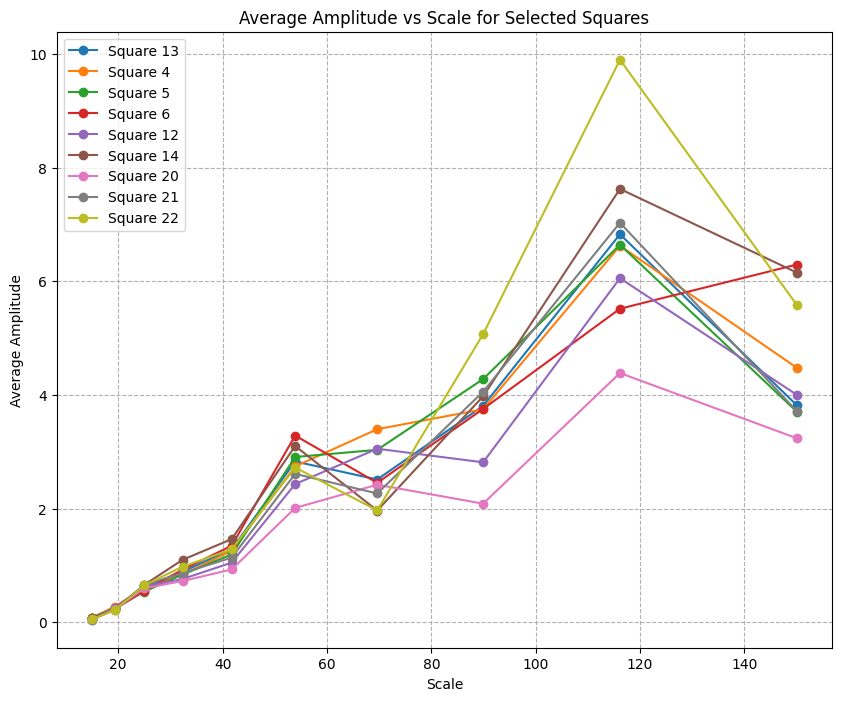

In [218]:
def check_squares(square_numbers, num_squares_per_row, num_squares_per_col, square_size, overlap, data_shape, scales, average_amplitudes_all_squares):
    step_size = int(square_size * (1 - overlap))

    # Check if the square numbers are within the valid range
    for square_number in square_numbers:
        if square_number < 0 or square_number >= num_squares_per_row * num_squares_per_col:
            raise ValueError(f"Invalid square number {square_number}. It must be within the valid range.")

    plt.figure(figsize=(10, 8))
    
    for square_number in square_numbers:
        i = (square_number // num_squares_per_row) * step_size
        j = (square_number % num_squares_per_row) * step_size

        # Get the average amplitudes for the specified square
        average_amplitudes = average_amplitudes_all_squares[square_number]

        # Plot the Average Amplitude vs Scale plot
        plt.plot(scales, average_amplitudes, marker='o', linestyle='-', label=f'Square {square_number}')

    plt.xlabel('Scale')
    plt.ylabel('Average Amplitude')
    plt.title('Average Amplitude vs Scale for Selected Squares')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

# Example usage:
square_number = 13
square_numbers = compute_neighbors(square_number, square_size, overlap, data_shape)
#square_numbers = [0, 1, 2, 3]  # Replace with the list of desired square numbers
check_squares([square_number]+square_numbers, num_squares_per_row, num_squares_per_col, square_size, overlap, data_shape, scales, average_amplitudes_all_squares)

